Adaptacion de [Basic NLP, EDA & TensorFlow - Real or Fake tweets](https://www.kaggle.com/galvaowesley/basic-nlp-eda-tensorflow-real-or-fake-tweets) de Wesley Galvão

Basic NLP with TensorFlow - Prediction of real or fake disaster tweets
===
​
Wesley Galvão 
​
Aug, 2020
​

# Introduction
​
This notebook contains an introductory approach to Natural Language Processing techniques in order to model and build a machine model that predicts which Tweets are about real disasters and which one's aren't. 
​
For this purpose, techniques of exploratory data analysis, cleaning and tensorflow library were used.
​
This work was based on others and was properly referenced in the references section.
​
I hope you enjoy reading.  

# About the Dataset

According the [competition description](https://www.kaggle.com/c/nlp-getting-started/data), the data characteristics are:

Each sample in the train and test set has the following information:

* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* he location the tweet was sent from (may also be blank)

Columns

* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


## Importing required libraries

In [1]:
import pandas as pd # data processing
import numpy as np  # linear algebra

# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# TensorFlow and libraries for preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Preprocessing libraries
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import gensim
import string
# Counter function
from collections import Counter

#WordCloud
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
# create text with Markdown from within code cells¶
from IPython.display import Markdown as md 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Loading dataset

In [2]:
# Load the dataset
train_df = pd.read_csv("https://raw.githubusercontent.com/DanielEduardoLopez/DEVF-DeepLearning/main/Chall2_train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/DanielEduardoLopez/DEVF-DeepLearning/main/Chall2_test.csv")
submission = pd.read_csv("https://raw.githubusercontent.com/DanielEduardoLopez/DEVF-DeepLearning/main/Chall2_sample_submission.csv")

## Dataset shape

In [3]:
# Head
train_df.head(4)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1


In [4]:
# Datasets shape
print('Train dataset:\n{} rows\n{} columns'.format(train_df.shape[0], train_df.shape[1]))
print('\nTest dataset:\n{} rows\n{} columns'.format(test_df.shape[0], test_df.shape[1]))

Train dataset:
7613 rows
5 columns

Test dataset:
3263 rows
4 columns


# Exploratory Data Analysis

In this section we'll perform some EDA techiniques, like chart plotting and features summarising. 

## Target variable characteristics

Analyses of `target` column.

### Amount

We can get the amount of real disaster and not real disaster tweets. 

In [5]:
# Count target values by its factor
x = train_df.target.value_counts()
md("The amount disaster tweets is {}. And the amount for not disaster is {}.".
     format(x[1], x[0]))
md

IPython.core.display.Markdown

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Target')

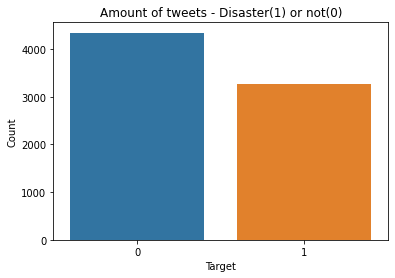

In [6]:
# Add title
plt.title("Amount of tweets - Disaster(1) or not(0)")
# Bar chart showing amount of both target values
sns.barplot(x.index, x)
# Add label for vertical axis
plt.ylabel("Count")
# Add label for hotizontal axis
plt.xlabel("Target")

### Proportion

We can also calculate target values proportion and visualize them. 

In [7]:
proportion = x/train_df.shape[0] # Compute the tweets proportion by target
md("The percentual of disaster tweets is {}%, and {}% for not disaster.".
     format(round(proportion[1]*100,0),round(proportion[0]*100, 0)))

The percentual of disaster tweets is 43.0%, and 57.0% for not disaster.

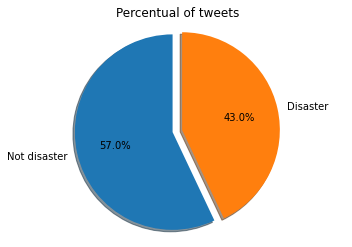

In [8]:
# Reference: https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_features.html
# Pie chart

fig1, ax1 = plt.subplots()
ax1.pie(proportion, 
        explode = (0, 0.1), # only "explode" the 2nd slice
        labels  = ['Not disaster', 'Disaster'], 
        autopct = '%1.1f%%',
        shadow = True, 
        startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Percentual of tweets")
plt.show()

## Text variable characteristics

To understand the distribution of tweets, it's necessary explore the `text` column. First, we create two new features to get some statistics.

### New features

The new features are number of characters (or text lenght) and number of words for each tweet.

In [9]:
# Create a new feature with text lenght, or number of characters
train_df['length'] = train_df['text'].str.len()
# Create a new feature with number of words
train_df['num_words'] = train_df['text'].str.split().map(lambda x: len(x))
train_df.head(3)

,id,keyword,location,text,target,length,num_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22


### Text lenght

Main statistics

In [10]:
# Text length summary by target
train_df.groupby(['target']).length.describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,4342.0,95.706817,35.885924,7.0,68.0,101.0,130.0,157.0
1,3271.0,108.113421,29.309854,14.0,88.0,115.0,136.0,151.0


Now, we plot the histogram to visualize the distribution. 

Text(0.5, 1.0, 'Disaster')

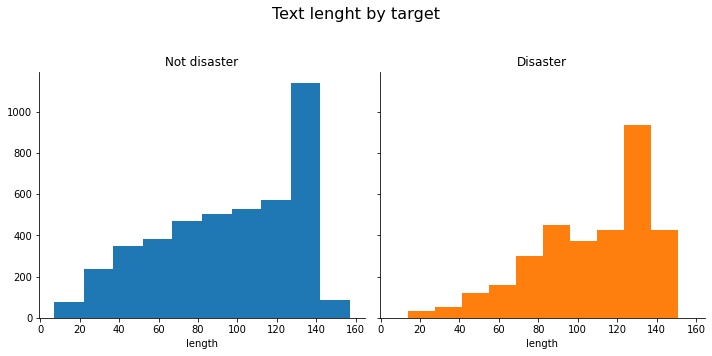

In [11]:
# Facet a plot by target column
g = sns.FacetGrid(train_df, col = 'target', height = 5, hue = 'target')
# Plot a histogram chart
g.map(plt.hist, "length")
# Adjust title position
g.fig.subplots_adjust(top=0.8)
# Add general title
g.fig.suptitle('Text lenght by target', fontsize=16)
# Set title to each chart
axes = g.axes.flatten()
axes[0].set_title("Not disaster")
axes[1].set_title("Disaster")

### Number of words

Similarly, here are some statistics and graphs that show the distribution of number of words.

In [12]:
# number of words summary by target
train_df.groupby(['target']).num_words.describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,4342.0,14.704744,6.161564,1.0,10.0,15.0,19.0,31.0
1,3271.0,15.167533,5.096806,2.0,11.0,15.0,19.0,30.0


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Disaster')

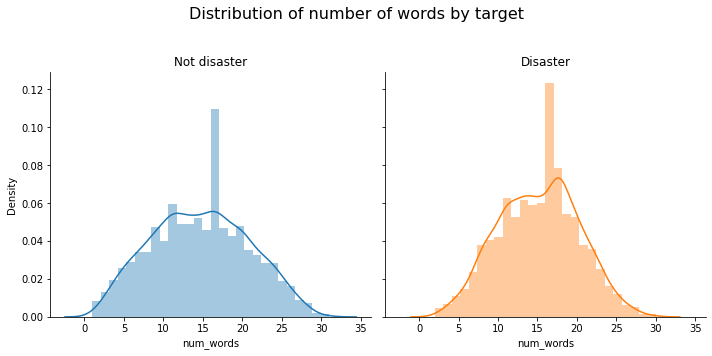

In [13]:
# Facet a plot by target column
g = sns.FacetGrid(train_df, col = 'target', height = 5, hue = 'target')
# Plot a histogram chart
g.map(sns.distplot, "num_words")
# Adjust title position
g.fig.subplots_adjust(top=0.8)
# Add general title
g.fig.suptitle('Distribution of number of words by target', fontsize=16)
# Set title to each chart
axes = g.axes.flatten()
axes[0].set_title("Not disaster")
axes[1].set_title("Disaster")

Text(0.5, 0, 'Target')

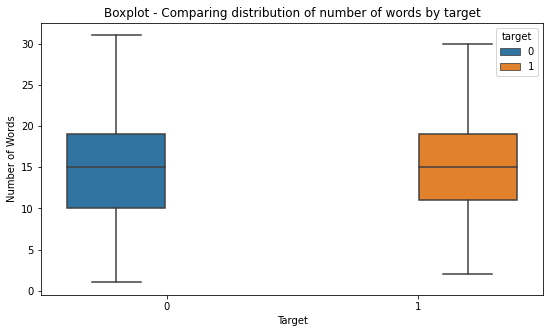

In [14]:
plt.figure(figsize=(9,5))
# Add title
plt.title("Boxplot - Comparing distribution of number of words by target")
# Boxplot
sns.boxplot(x = "target", y = "num_words", hue="target", data = train_df)
# Add label for vertical axis
plt.ylabel("Number of Words")
# Add label for hotizontal axis
plt.xlabel("Target")

#### Unique words

In [15]:
# Reference https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud#kln-160
# Function to compute many unique words have this text
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [16]:
# Unique words
text_values = train_df["text"]

counter = counter_word(text_values)
md("The training dataset has {} unique words".format(len(counter)))

The training dataset has 31924 unique words

## Keyword variable characteristics

What are the top 20 keywords? 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

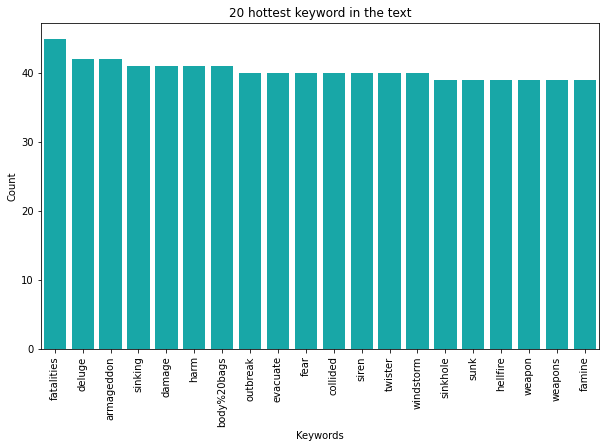

In [17]:
# Groups the top 20 keywords
x = train_df.keyword.value_counts()[:20]
# Set the width and height of the figure
plt.figure(figsize=(10,6))
# Add title
plt.title("20 hottest keyword in the text")
# Bar chart showing amount of both target values
sns.barplot(x.index, x, color="c")
# Add label for vertical axis
plt.ylabel("Count")
# Add label for hotizontal axis
plt.xlabel("Keywords")
# Rotate the label text for hotizontal axis
plt.xticks(rotation=90)

### Word Cloud

We can explore the most used keywords through the word cloud graphic.

#### Function to create a Word Cloud

In [18]:
# Reference: https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud#6.-Train-Test-Split
# Download a image to mask the wordcloud
!wget --no-check-certificate \
  https://i.imgur.com/tyCaXHH.jpg \
    -O /tmp/Twitter_Logo.jpg

STOPWORDS.add('NaN')  # remove NaN to the world Cloud
STOPWORDS.add('https') # remove https to the world Cloud

def create_word_cloud(text):
    
    comment_words = ' '
    stopwords = set(STOPWORDS) 
    
    for val in text: 

        # convert each val to string type 
        val = str(val)
        # split the value 
        tokens = val.split() 
        # Converts each token to lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '
            
    maskArray = np.array(Image.open("/tmp/Twitter_Logo.jpg"))
    wordcloud = WordCloud(width = 5000, height = 4000,
                    background_color ='white',
                    mask = maskArray,      
                    stopwords = stopwords,
                    min_font_size = 10)
    wordcloud.generate(comment_words)   
    
    # plot the WordCloud image                        
    plt.figure(figsize = (12, 12)) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

--2022-12-03 05:27:35--  https://i.imgur.com/tyCaXHH.jpg
Resolving i.imgur.com (i.imgur.com)... 151.101.24.193
Connecting to i.imgur.com (i.imgur.com)|151.101.24.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103166 (101K) [image/jpeg]
Saving to: ‘/tmp/Twitter_Logo.jpg’

/tmp/Twitter_Logo.j 100%[===================>] 100.75K  --.-KB/s    in 0.01s   

2022-12-03 05:27:35 (7.06 MB/s) - ‘/tmp/Twitter_Logo.jpg’ saved [103166/103166]



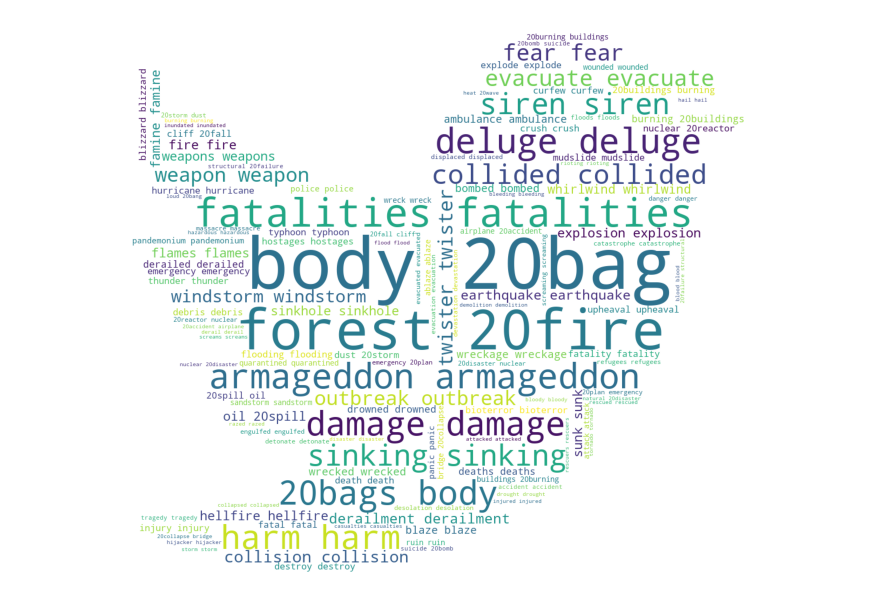

In [19]:
# Create a WordCloud from keyword values
text = train_df.keyword.values
create_word_cloud(text)

## Location variable characteristics

What are the top 20 location? 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

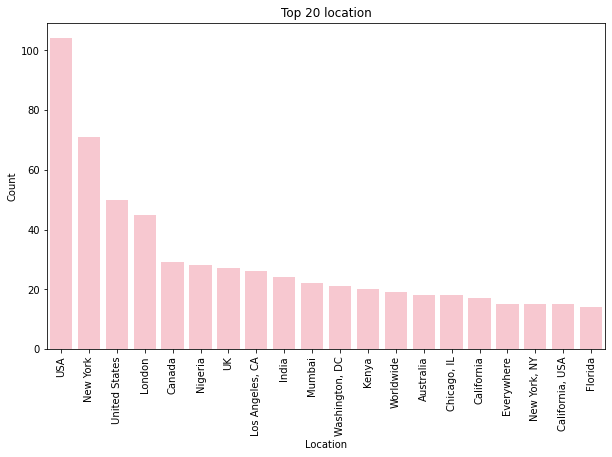

In [20]:
# Groups the top 20 location
x = train_df.location.value_counts()[:20]
# Set the width and height of the figure
plt.figure(figsize=(10,6))
# Add title
plt.title("Top 20 location")
# Bar chart showing amount of both target values
sns.barplot(x.index, x, color = "pink")
# Add label for vertical axis
plt.ylabel("Count")
# Add label for hotizontal axis
plt.xlabel("Location")
# Rotate the label text for hotizontal axis
plt.xticks(rotation=90)

# Challenge

In [21]:
######Preprocessing
####Data Cleaning
#removing emoji                   # Reference https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
import re
import sys

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

print(remove_emoji("Oh no, a hurricane is happening here 🌪️🚫😫")) 
# Apply removing emoji function to dataset
train_df['text'] = train_df['text'].apply(lambda x: remove_emoji(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_emoji(x))

Oh no, a hurricane is happening here 


In [22]:
#removing URLS                    # Reference https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud#5.-Cleaning-the-text


# Reference https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud#5.-Cleaning-the-text
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
def remove_url(text):
    no_url = pattern.sub(r'',text)
    return no_url

# Removing URL example
example = "Hey, look at this Data Science platform: https://www.kaggle.com"
print( remove_url(example) )

# Apply removing URL function to dataset
train_df['text'] = train_df['text'].apply(lambda x: remove_url(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_url(x))


Hey, look at this Data Science platform: 


In [ ]:
#removing HTML Tags               # Reference https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#Data-Cleaning





In [ ]:
#Convert abbrevation to text            # reference: https://www.kaggle.com/rftexas/text-only-kfold-bert




In [23]:
#removing stop words                    # Reference https://www.kaggle.com/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud#kln-160

def clean_text(text):
 
    text = re.sub('[^a-zA-Z]', ' ', text)  
    text = text.lower()  
    # split to array(default delimiter is " ") 
    text = text.split()      
    text = [w for w in text if not w in set(stopwords.words('english'))]
    text = ' '.join(text)    
            
    return text
# Apply clean text
train_df['text'] = train_df['text'].apply(lambda x : clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x : clean_text(x))


In [24]:
train_df.head()

,id,keyword,location,text,target,length,num_words
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,69,13
1,4,NaN,NaN,forest fire near la ronge sask canada,1,38,7
2,5,NaN,NaN,residents asked shelter place notified officer...,1,133,22
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1,65,8
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,88,16


In [25]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


In [ ]:
#####Splitin trining dataset and testing dataset

In [26]:
len(train_df.text)

7613

In [27]:
len(train_df.text) * 0.80

6090.400000000001

In [28]:
# Create training subsets
training_set = train_df.text[0:6090]

In [29]:
# Create testing subsets
testing_set = train_df.text[6091:7613]

In [ ]:
#####Tokenization

In [30]:
# Initialize tokenizer
tokenizer = Tokenizer(num_words = 10000)

# Fitting the training dataset
tokenizer.fit_on_texts(training_set)

# Create a words dictionary
word_index = tokenizer.word_index
print(word_index)

{'amp': 1, 'like': 2, 'fire': 3, 'get': 4, 'via': 5, 'new': 6, 'people': 7, 'news': 8, 'emergency': 9, 'one': 10, 'disaster': 11, 'body': 12, 'video': 13, 'burning': 14, 'would': 15, 'u': 16, 'buildings': 17, 'police': 18, 'us': 19, 'man': 20, 'day': 21, 'time': 22, 'crash': 23, 'first': 24, 'california': 25, 'still': 26, 'got': 27, 'two': 28, 'know': 29, 'back': 30, 'going': 31, 'full': 32, 'accident': 33, 'w': 34, 'world': 35, 'nuclear': 36, 'attack': 37, 'see': 38, 'go': 39, 'today': 40, 'love': 41, 'gt': 42, 'may': 43, 'rt': 44, 'youtube': 45, 'year': 46, 'many': 47, 'watch': 48, 'let': 49, 'dead': 50, 'collapse': 51, 'hiroshima': 52, 'car': 53, 'mass': 54, 'life': 55, 'years': 56, 'want': 57, 'good': 58, 'death': 59, 'work': 60, 'best': 61, 'train': 62, 'last': 63, 'fires': 64, 'could': 65, 'say': 66, 'think': 67, 'families': 68, 'way': 69, 'home': 70, 'killed': 71, 'hot': 72, 'forest': 73, 'fatal': 74, 'need': 75, 'war': 76, 'black': 77, 'take': 78, 'legionnaires': 79, 'reddit': 

In [31]:
#####Sequencing
# Create sequences of tokens that represent each sentence 

sequences = tokenizer.texts_to_sequences(training_set)

print(sequences)

[[3675, 695, 260, 43, 1274, 3676, 19], [73, 3, 119, 570, 5479, 5480, 1183], [1445, 1184, 1627, 497, 5481, 1446, 115, 1627, 497, 973, 1185], [7, 3677, 1075, 115, 973, 25], [27, 1076, 335, 5482, 1275, 889, 1075, 5483, 87], [2241, 336, 25, 974, 607, 5484, 386, 1077, 387, 3, 5485, 1075], [95, 11, 571, 280, 975, 645, 116, 1628, 5486, 741, 1880, 1186], [120, 2242, 38, 3, 5487], [9, 115, 890, 442, 696, 572], [2243, 2244, 191, 183], [498, 7, 405, 136, 281, 423], [742, 443, 2245, 146, 2246, 2780, 522, 548, 159, 443, 2245, 203, 203, 5488, 116], [2781, 116, 1276, 5489, 2245, 460, 573, 2782], [95, 3678, 574, 1277, 3678], [102, 87, 356, 2247, 53, 23, 302], [20], [41, 5490], [219, 1278], [53, 646], [5491], [2783], [795, 388], [41, 5492], [3679, 21], [5493], [69, 1881, 137], [1078, 63, 337], [41, 1882], [5494], [2, 3680], [261], [5495, 2248, 2784, 375], [168, 608, 743, 571, 891, 44], [5496, 302, 8, 2785, 523, 147, 375, 796], [1279, 147, 375], [1629, 697, 98, 797, 63, 138, 375], [5497, 3681, 1883, 117

In [32]:
longi = []
for i in sequences:
  longi.append(len(i))

print(max(longi))

25


In [33]:
####Padding
# Create padding sequences for training sentences 
padded = pad_sequences(sequences, padding = 'post', maxlen=25)
print("\nWord Index = " , word_index)
print("\nSequences = " , sequences)
print("\nPadded Sequences:")
print(padded)


Word Index =  {'amp': 1, 'like': 2, 'fire': 3, 'get': 4, 'via': 5, 'new': 6, 'people': 7, 'news': 8, 'emergency': 9, 'one': 10, 'disaster': 11, 'body': 12, 'video': 13, 'burning': 14, 'would': 15, 'u': 16, 'buildings': 17, 'police': 18, 'us': 19, 'man': 20, 'day': 21, 'time': 22, 'crash': 23, 'first': 24, 'california': 25, 'still': 26, 'got': 27, 'two': 28, 'know': 29, 'back': 30, 'going': 31, 'full': 32, 'accident': 33, 'w': 34, 'world': 35, 'nuclear': 36, 'attack': 37, 'see': 38, 'go': 39, 'today': 40, 'love': 41, 'gt': 42, 'may': 43, 'rt': 44, 'youtube': 45, 'year': 46, 'many': 47, 'watch': 48, 'let': 49, 'dead': 50, 'collapse': 51, 'hiroshima': 52, 'car': 53, 'mass': 54, 'life': 55, 'years': 56, 'want': 57, 'good': 58, 'death': 59, 'work': 60, 'best': 61, 'train': 62, 'last': 63, 'fires': 64, 'could': 65, 'say': 66, 'think': 67, 'families': 68, 'way': 69, 'home': 70, 'killed': 71, 'hot': 72, 'forest': 73, 'fatal': 74, 'need': 75, 'war': 76, 'black': 77, 'take': 78, 'legionnaires':

In [34]:
# Create padding sequences for testing sentences 
sequences_test = tokenizer.texts_to_sequences(testing_set)
print("\nTest Sequence = ", sequences_test)




Test Sequence =  [[390, 1252, 813, 70, 412, 618, 449, 22], [1298, 53, 1252, 1765, 8165], [9929, 10, 1252, 2130], [390, 1252, 813, 70, 412, 618, 449, 22], [1386, 9647, 966, 897, 185, 923, 1252, 4357], [7596, 2177, 1252, 4937, 4043], [390, 1252, 813, 70, 412, 618, 449, 22], [573, 893, 1252, 2, 3156, 2946], [3108, 3096, 1252, 3889, 1117, 3236, 49, 81, 425, 139], [1491, 3528, 293, 1252, 314, 1262, 734, 1724], [906, 1252, 989], [1252, 989, 1635, 3508, 3156], [390, 1252, 813, 70, 412, 618, 449, 22], [511, 1722, 2033, 65, 2735, 321, 1252], [573, 1, 893, 1252, 2, 3156, 2946], [733, 4, 1252, 989, 90], [701, 7363, 2552, 2450, 2212, 269, 2450, 1252, 9489], [163, 2, 1252, 636, 320, 735, 78, 787], [8, 718, 1315, 8369, 3081, 8294, 5255, 1582, 1252, 531, 9307, 6], [795, 1966, 1252, 3786], [1252, 2454, 3660], [616, 38, 195, 1454, 1252, 1252, 341, 821, 282, 38, 81], [390, 1252, 813, 70, 412, 618, 449, 22], [1252, 1465, 1241, 867, 771, 549, 41, 1806, 1812], [1252, 3368, 427, 65, 320, 159, 1753, 1648, 6

In [35]:
longi = []
for i in sequences_test:
  longi.append(len(i))

print(max(longi))

19


In [36]:
padded_test = pad_sequences(sequences_test, padding = 'post', maxlen=25)

print("\nPadded Test Sequences:")
print(padded_test)


Padded Test Sequences:
[[ 390 1252  813 ...    0    0    0]
 [1298   53 1252 ...    0    0    0]
 [9929   10 1252 ...    0    0    0]
 ...
 [ 789  604 4901 ...    0    0    0]
 [  18  825  327 ...    0    0    0]
 [ 106  101  334 ...    0    0    0]]


In [37]:
#####Modeling and Training
# Convert the sets to array to get it to work with TensorFlow
features_padded_train = np.array(padded)
features_padded_test = np.array(padded_test)
labels_train = np.array(train_df.target[0:6090])
labels_test = np.array(train_df.target[6091:7613])

In [38]:
####Modeling    # Reference https://www.kaggle.com/galvaowesley/nlp-tensorflow-predicting-sarcastic-sentences
# Parameters
vocab_size = 10000
embedding_dim = 16
max_length = 25
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

# Create a model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [39]:
# Modelo compile for binary classification
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [40]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 16)            160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Train the model
num_epochs = 10
history = model.fit(features_padded_train, labels_train, epochs=num_epochs, validation_data=(features_padded_test, labels_test), verbose=1)

Epoch 1/10
191/191 [==============================] - 2s 13ms/step - loss: 0.2298 - accuracy: 0.9135 - val_loss: 0.4508 - val_accuracy: 0.8035
Epoch 2/10
191/191 [==============================] - 2s 10ms/step - loss: 0.1970 - accuracy: 0.9314 - val_loss: 0.4667 - val_accuracy: 0.7884
Epoch 3/10
191/191 [==============================] - 2s 10ms/step - loss: 0.1710 - accuracy: 0.9411 - val_loss: 0.4840 - val_accuracy: 0.7871
Epoch 4/10
191/191 [==============================] - 2s 10ms/step - loss: 0.1505 - accuracy: 0.9471 - val_loss: 0.5069 - val_accuracy: 0.7832
Epoch 5/10
191/191 [==============================] - 2s 11ms/step - loss: 0.1346 - accuracy: 0.9519 - val_loss: 0.5297 - val_accuracy: 0.7779
Epoch 6/10
191/191 [==============================] - 2s 9ms/step - loss: 0.1211 - accuracy: 0.9568 - val_loss: 0.5559 - val_accuracy: 0.7707
Epoch 7/10
191/191 [==============================] - 2s 10ms/step - loss: 0.1092 - accuracy: 0.9612 - val_loss: 0.5817 - val_accuracy: 0.7727


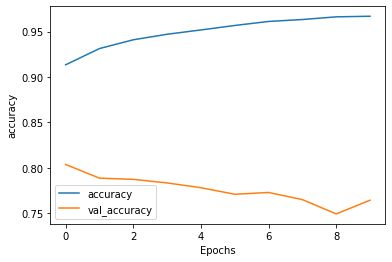

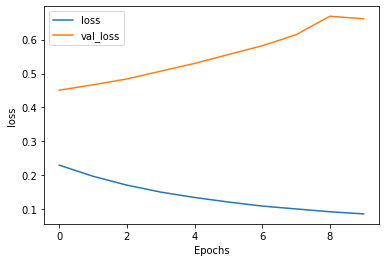

In [43]:
#### Evaluation
#plot loss and accuracy
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")




In [ ]:
###Confusion matrix
# predict clases because is classification problem with the split test




In [ ]:
# Showing Confusion Matrix





In [ ]:
####Predicting
# Sequencing

sequences = tokenizer.texts_to_sequences(sentence)



In [ ]:
# Padding
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [ ]:
# Apply model prediction on submission sequences
print(model.predict(padded))

### Removing HTML tags

In [ ]:
# Reference https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#Data-Cleaning
pattern = re.compile('<.*?>')
def remove_html(text):
    no_html = pattern.sub(r'',text)
    return no_html

In [ ]:
# Removing HTML tags example
example = """<div>
<h1>NLP TensorFlow</h1>
<p>Predicting sarcastic sentences by Wesley Galvão </p>
<a href="https://www.kaggle.com/galvaowesley/nlp-tensorflow-predicting-sarcastic-sentences">Check it out</a>
</div>"""
remove_html(example)

'\nNLP TensorFlow\nPredicting sarcastic sentences by Wesley Galvão \nCheck it out\n'

In [ ]:
# Apply removing HTML tags function to dataset
train_df['text'] = train_df['text'].apply(lambda x: remove_html(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_html(x))

### Convert abbreviation to text

In [ ]:
# Dictionary of abbreviations
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [ ]:
# reference: https://www.kaggle.com/rftexas/text-only-kfold-bert
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [ ]:
# Appy abbreviation to text
train_df['text'] = train_df['text'].apply(lambda x: convert_abbrev_in_text(x))
test_df['text'] = test_df['text'].apply(lambda x: convert_abbrev_in_text(x))